# Titanic - Machine Learning from Disaster

The competition is simple: use machine learning to create a model that predicts which passengers survived the Titanic shipwreck.

[See more here](https://www.kaggle.com/competitions/titanic)


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from google.colab import drive # Para montar nuestro drive en la consola
import pandas as pd

In [ ]:
drive.mount('/content/drive') # Mount Google Drive

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Obtain the data
folder = '/content/drive/My Drive/datasets/titanic/'
filename_train = folder + 'train.csv'
filename_test = folder + 'test.csv'
filename_gender = folder + 'gender_submission.csv'

# Build the dataframes
df_train = pd.read_csv(filename_train, delimiter=',')
df_test = pd.read_csv(filename_test, delimiter=',')
df_gender = pd.read_csv(filename_gender, delimiter=',')

In [ ]:
# Delete rows that the age or embarked are missing
df_train = df_train.dropna(subset=['Age', 'Embarked'], axis=0)
# df_train[['Age']] = df_train[['Age']].fillna(np.nanmean(df_train['Age'].values), axis=0)
# df_train[['Embarked']] = df_train[['Embarked']].fillna(df_train['Embarked'].mode(), axis=0)

# Complete the test data set
# df_test = df_test.dropna(subset=['Age', 'Embarked'], axis=0)
df_test[['Age']] = df_test[['Age']].fillna(np.nanmean(df_test['Age'].values), axis=0)
df_test[['Fare']] = df_test[['Fare']].fillna(np.nanmean(df_test['Fare'].values), axis=0)

# Cabin also has missing values but it's not gonna be used for logistic regression

# Let see the summary of the datasets
print(df_train.info())
print(df_test.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 712 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  712 non-null    int64  
 1   Survived     712 non-null    int64  
 2   Pclass       712 non-null    int64  
 3   Name         712 non-null    object 
 4   Sex          712 non-null    object 
 5   Age          712 non-null    float64
 6   SibSp        712 non-null    int64  
 7   Parch        712 non-null    int64  
 8   Ticket       712 non-null    object 
 9   Fare         712 non-null    float64
 10  Cabin        183 non-null    object 
 11  Embarked     712 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 72.3+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pcl

In [ ]:
# Buid Dummies variables

# Sex feature
df_train.loc[df_train['Sex'] == 'female', 'Sex_Dummy'] = 1
df_train.loc[df_train['Sex'] == 'male', 'Sex_Dummy'] = 0

df_test.loc[df_test['Sex'] == 'female', 'Sex_Dummy'] = 1
df_test.loc[df_test['Sex'] == 'male', 'Sex_Dummy'] = 0

# Embarked feature
df_train = pd.concat([df_train, pd.get_dummies(df_train['Embarked'], prefix='Embarked')], axis=1)
df_test = pd.concat([df_test, pd.get_dummies(df_test['Embarked'], prefix='Embarked')], axis=1)

/usr/local/lib/python3.8/dist-packages/pandas/core/indexing.py:1684: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = infer_fill_value(value)
/usr/local/lib/python3.8/dist-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


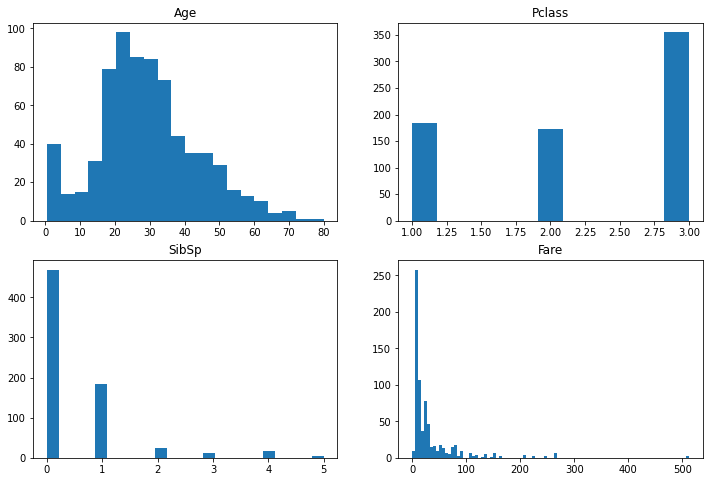

In [ ]:
# Studying the data
plt.figure(figsize=(12,8))

plt.subplot(221)
plt.title('Age')
plt.hist(df_train['Age'], bins='auto')

plt.subplot(222)
plt.title('Pclass')
plt.hist(df_train['Pclass'], bins='auto')

plt.subplot(223)
plt.title('SibSp')
plt.hist(df_train['SibSp'], bins='auto')

plt.subplot(224)
plt.title('Fare')
plt.hist(df_train['Fare'], bins='auto')

plt.show()

In [ ]:
# Libraries
import itertools
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import PolynomialFeatures
# Functions 

# Confusion Matrix plotting function
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize=(8,6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('Observation')
    plt.xlabel('Predict')

def metrics(cm, make_print=False):
  tp = cm[1, 1]
  fn = cm[0, 1]
  tn = cm[0, 0]
  fp = cm[1, 0]

  sensitivity = tp/(tp+fn)
  specificity = tn/(tn+fp)
  balanced_accuracy = (sensitivity + specificity)/2
  if make_print:
    print('Confusion Matrix: ')
    print(cm)
    print(f'sensitivity: {round(sensitivity, 4)}')
    print(f'specificity: {round(specificity, 4)}')
    print(f'balanced_accuracy: {round(balanced_accuracy, 4)}')
  return {'sensitivity': sensitivity, 
          'specificity': specificity, 
          'balanced_accuracy': balanced_accuracy}

def classifier (X, y, penalty='none', n=1, interaction=False, C=None, test_size=0.3):
  # n maxima potencia
  # C constante de penalizacion

  if interaction:
    poly = PolynomialFeatures(degree=n)
    new_X = poly.fit_transform(X)
  else:
    new_X = X.copy()
    for i in np.arange(2, n, 1):
      new_X = np.concatenate((new_X, X**i), axis=1)
  # Build sets
  X_train, X_test, y_train, y_test = train_test_split(new_X, y, test_size=test_size)

  # Rescale train
  scaler = MinMaxScaler()
  scaler.fit(X_train)
  X_train = scaler.transform(X_train)

  # Rescale test
  scaler = MinMaxScaler()
  scaler.fit(X_test)
  X_test = scaler.transform(X_test)

  # Model
  if C:
    regLog = LogisticRegression(penalty=penalty, class_weight='balanced', C=C, max_iter=5e3) # Default max_iter is 100 (1e2)
  else:
    regLog = LogisticRegression(penalty=penalty, class_weight='balanced', max_iter=5e3) # Default max_iter is 100 (1e2)
  regLog.fit(X_train, y_train)

  # Predict and CM
  score_train = regLog.score(X_train, y_train)
  score_test = regLog.score(X_test, y_test)

  y_train_pred = regLog.predict(X_train)
  y_test_pred = regLog.predict(X_test)

  cm_train = confusion_matrix(y_train_pred, y_train)
  cm_test = confusion_matrix(y_test_pred, y_test)
  
  metrics_train = metrics(cm_train)
  metrics_test = metrics(cm_test)

  proba_train = regLog.predict_proba(X_train)
  proba_test = regLog.predict_proba(X_test)
  return {
      'train': {
          'score': score_train, 
          'cm': cm_train,
          'sensitivity': metrics_train['sensitivity'],
          'specificity': metrics_train['specificity'],
          'balanced_accuracy': metrics_train['balanced_accuracy'],
          'proba': proba_train,
          'y_train': y_train,
          'X_train': X_train,
      },
      'test': {
          'score': score_test, 
          'cm': cm_test,
          'sensitivity': metrics_test['sensitivity'],
          'specificity': metrics_test['specificity'],
          'balanced_accuracy': metrics_test['balanced_accuracy'],
          'proba': proba_test,
          'y_test': y_test,
          'X_test': X_test,
      },
      'model': regLog
  }

def grid_search(n_values, C_values, iterations:int):
  mean_BA_train = np.zeros((len(n_values), len(C_values)))
  mean_BA_test = np.zeros((len(n_values), len(C_values)))

  for xx, n in enumerate(n_values):
    for yy, C in enumerate(C_values):
      print(f"Procesando n = {n}, C = {C}")
      ba_train = []
      ba_test = []
      for i in range(iterations):
        result = classifier(X_train, y_train, penalty='l2', interaction=True, n=n, C=C)
        ba_train.append(result['train']['balanced_accuracy'])
        ba_test.append(result['test']['balanced_accuracy'])
      mean_BA_train[xx, yy] = np.mean(ba_train)
      mean_BA_test[xx, yy] = np.mean(ba_test)

  return {'mean_BA_train': mean_BA_train,
          'mean_BA_test': mean_BA_test,
          }          

In [ ]:
# Features
features = ['Age', 'Sex_Dummy', 'Pclass', 'SibSp', 'Fare', 'Embarked_C', 'Embarked_Q', 'Embarked_S']
X_train = df_train[features].values.copy()
y_train = df_train['Survived'].copy()

X_validation = df_test[features].values.copy() # Test

result = classifier(X_train, y_train, penalty='l2', interaction=True, n=10, C=1)

from sklearn.preprocessing import MinMaxScaler
# Rescale test
scaler = MinMaxScaler()
scaler.fit(X_validation)
X_validation = scaler.transform(X_validation)



In [ ]:
%%time
# Grid Search
# -----------------

# Features
features = ['Age', 'Sex_Dummy', 'Pclass', 'SibSp', 'Fare', 'Embarked_C', 'Embarked_Q', 'Embarked_S']
X_train = df_train[features].values.copy()
y_train = df_train['Survived'].copy()

# Build the grid
C_values = np.array([3, 3.25, 3.5, 3.75, 4, 4.25, 4.5, 4.75])
n_values = np.arange(2, 5, 1)

result_grid_search = grid_search(n_values, C_values, iterations=200)

Procesando n = 2, C = 3.0
Procesando n = 2, C = 3.25
Procesando n = 2, C = 3.5
Procesando n = 2, C = 3.75
Procesando n = 2, C = 4.0
Procesando n = 2, C = 4.25
Procesando n = 2, C = 4.5
Procesando n = 2, C = 4.75
Procesando n = 3, C = 3.0
Procesando n = 3, C = 3.25
Procesando n = 3, C = 3.5
Procesando n = 3, C = 3.75
Procesando n = 3, C = 4.0
Procesando n = 3, C = 4.25
Procesando n = 3, C = 4.5
Procesando n = 3, C = 4.75
Procesando n = 4, C = 3.0
Procesando n = 4, C = 3.25
Procesando n = 4, C = 3.5
Procesando n = 4, C = 3.75
Procesando n = 4, C = 4.0
Procesando n = 4, C = 4.25
Procesando n = 4, C = 4.5
Procesando n = 4, C = 4.75
CPU times: user 7min 21s, sys: 4min 40s, total: 12min 1s
Wall time: 6min 16s


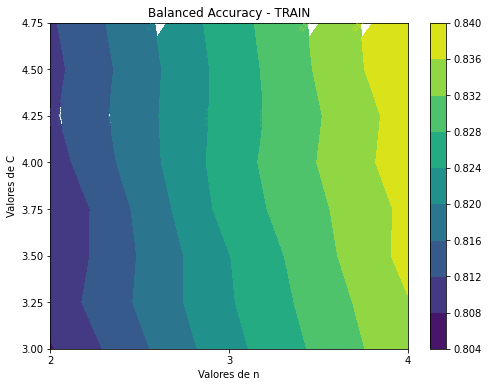

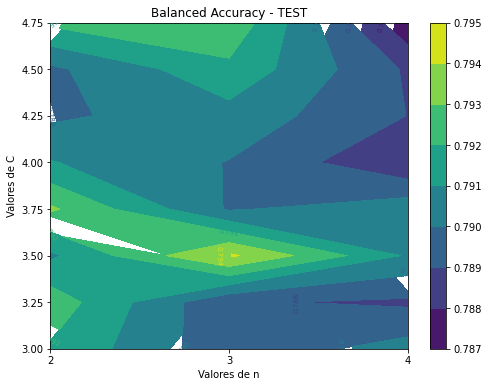

In [ ]:
# Plot test grid and train grid

plt.figure(figsize=(8,6))
contours = plt.contourf(n_values, C_values, np.transpose(result_grid_search['mean_BA_train']))
plt.clabel(contours, inline=1, fontsize=7)
plt.colorbar()
plt.xticks(n_values)
plt.yticks(C_values)
plt.xlabel('Valores de n')
plt.ylabel('Valores de C')
plt.title('Balanced Accuracy - TRAIN')
plt.show()

plt.figure(figsize=(8,6))
contours = plt.contourf(n_values, C_values, np.transpose(result_grid_search['mean_BA_test']))
plt.clabel(contours, inline=1, fontsize=7)
plt.colorbar()
plt.xlabel('Valores de n')
plt.ylabel('Valores de C')
plt.xticks(n_values)
plt.yticks(C_values)
plt.title('Balanced Accuracy - TEST')
plt.show()

Balanced Accuracy = 0.810752688172043
AUC = 0.8445340501792116
F1 Score = 0.7796610169491527


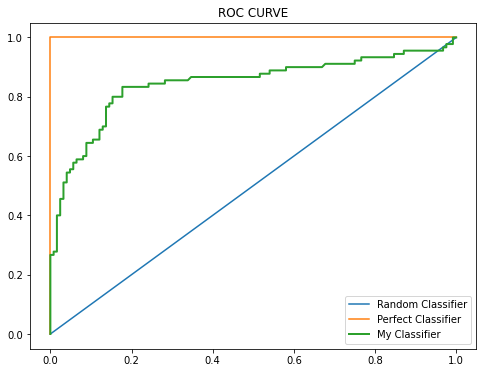

In [ ]:
# Train with best hiperparameters

# Features
features = ['Age', 'Sex_Dummy', 'Pclass', 'SibSp', 'Fare', 'Embarked_C', 'Embarked_Q', 'Embarked_S']
X_train = df_train[features].values.copy()
y_train = df_train['Survived'].copy()

result = classifier(X_train, y_train, penalty='l2', interaction=True, n=3, C=5)

print(f"Balanced Accuracy = {result['test']['balanced_accuracy']}")

from sklearn.metrics import roc_curve, roc_auc_score, f1_score

FPR, TPR, Thresholds = roc_curve(result['test']['y_test'], result['model'].predict_proba(result['test']['X_test'])[:, 1], drop_intermediate=True)
auc = roc_auc_score(result['test']['y_test'], result['model'].predict_proba(result['test']['X_test'])[:, 1])
f1 = f1_score(result['test']['y_test'], result['model'].predict(result['test']['X_test']))

print(f"AUC = {auc}")
print(f"F1 Score = {f1}")

FPR_random, TPR_random, t_rendom = roc_curve(result['test']['y_test'], np.random.rand(len(result['test']['y_test'])), drop_intermediate=True)

plt.figure(figsize = (8, 6))
plt.title('ROC CURVE')
plt.plot([0, 1], [0, 1], label='Random Classifier')
plt.plot([0, 0, 1], [0, 1, 1], label='Perfect Classifier')
plt.plot(FPR, TPR, linewidth = 2, label='My Classifier')
plt.legend()
plt.show()

In [ ]:
# Test with test data given by Kaggle

from sklearn.preprocessing import PolynomialFeatures, MinMaxScaler

features = ['Age', 'Sex_Dummy', 'Pclass', 'SibSp', 'Fare', 'Embarked_C', 'Embarked_Q', 'Embarked_S']
features_with_id = ['PassengerId', 'Age', 'Sex_Dummy', 'Pclass', 'SibSp', 'Fare', 'Embarked_C', 'Embarked_Q', 'Embarked_S']
X_real_test = df_test[features_with_id].copy()
print(X_real_test.info())
PassengerId  = X_real_test['PassengerId']
X_real_test = X_real_test[features]

poly = PolynomialFeatures(degree=3)
X_real_test_modified = poly.fit_transform(X_real_test.values)

# Rescale 
scaler = MinMaxScaler()
scaler.fit(X_real_test_modified)
X_real_test_modified = scaler.transform(X_real_test_modified)


y_pred = result['model'].predict(X_real_test_modified)
y_pred_score = result['model'].predict_proba(X_real_test_modified)


df_final = pd.DataFrame({'PassengerId': PassengerId, 'Survived': y_pred})
df_final = df_final.reset_index(drop=True)

print(y_pred.shape)
print(PassengerId.shape)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Age          418 non-null    float64
 2   Sex_Dummy    418 non-null    float64
 3   Pclass       418 non-null    int64  
 4   SibSp        418 non-null    int64  
 5   Fare         418 non-null    float64
 6   Embarked_C   418 non-null    uint8  
 7   Embarked_Q   418 non-null    uint8  
 8   Embarked_S   418 non-null    uint8  
dtypes: float64(3), int64(3), uint8(3)
memory usage: 20.9 KB
None
(418,)
(418,)


In [ ]:
df_final.info()
df_final.to_csv('result_2.csv', index=False)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   PassengerId  418 non-null    int64
 1   Survived     418 non-null    int64
dtypes: int64(2)
memory usage: 6.7 KB
